In [1]:
import numpy as np
import pandas as pd
import calc_rates
import test_model
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.integrate
import scipy.optimize
import importlib
import multiprocessing
import logging
import collections
import pickle
import optimize_process
import scipy.interpolate
import rpy2
import rpy2.robjects
import rpy2.robjects.conversion
import rpy2.robjects.pandas2ri
import rpy2.robjects.packages
import color_scheme
import os
import color_scheme

plt.rcParams["text.usetex"] = True
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath}"
    + r"\usepackage{siunitx}"
    + r"\sisetup{detect-all}"
    + r"\usepackage{lmodern}"
    + r"\input{"
    + f"{os.path.abspath('../data/00_abbrevs.tex')}"
    + r"}"
    + r"\usepackage{sansmathfonts}"
)

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

plt.rcParams['savefig.dpi'] = 300
plt.rcParams["font.size"] = 14
figpath = "../figs/"
data_dir = "../data/"

During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MONETARY failed, using "C" 
3: Setting LC_PAPER failed, using "C" 
4: Setting LC_MEASUREMENT failed, using "C" 


In [5]:
# yields
Y_XG = 0.627
Y_PG = 0.652
c_feed = 390

X0 = 30

In [6]:
with open(f"{data_dir}DoE.pickle", "rb") as f:
    DoE = pickle.load(f)

with open(f"{data_dir}val_results.pickle", "rb") as f:
    val_results = pickle.load(f)

In [7]:
def create_df(results, variable_names):
    """
    creates a dataframe from imp_euler return value
    """
    return pd.DataFrame(results, columns=["t"] + variable_names).set_index("t")


class F:
    def __init__(self, X0, mu_feed, ode, T, Y_XG, c_feed) -> None:
        self.X0 = X0
        self.mu_feed = mu_feed
        self.ode = ode
        self.T = T
        self.Y_XG = Y_XG
        self.c_feed = c_feed
        self.f0 = self.X0 * self.mu_feed / (self.Y_XG * self.c_feed)

    def f(self, t, x):
        f = self.f0 * np.exp(self.mu_feed * t)
        return self.ode.f(x, [f, self.T])


class GetOpt:
    def __init__(self, ode, X0, Y_PG, c_feed) -> None:
        self.ode = ode
        self.X0 = X0
        self.Y_XG = Y_XG
        self.c_feed = c_feed

    def f_min(self, u, rtol=1e-12):
        mu_feed = u[0]
        T = u[1]
        x0 = [self.X0, 0, 0, 1]

        f = F(X0, mu_feed, self.ode, T, self.Y_XG, self.c_feed)

        sol = scipy.integrate.solve_ivp(
            f.f, [0, 12], x0, method="LSODA", rtol=1e-12, min_step=1e-6
        )
        return -sol.y[1][-1] / sol.y[0][-1]

    def opt(self):
        opt = scipy.optimize.minimize(
            fun=self.f_min, x0=[0.12, 304.15], bounds=[(0, 0.5), (300, 315)]
        )
        return opt


def get_opt_errors(ode_real, ode_est, X0, Y_XG, c_feed, df_data, DoE):

    real_opt = GetOpt(ode_real, X0, Y_XG, c_feed).opt()
    est_opt = GetOpt(ode_est, X0, Y_XG, c_feed).opt()

    mu_f_opt = real_opt.x[0]
    T_opt = real_opt.x[1]

    mu_f_est = est_opt.x[0]
    T_est = est_opt.x[1]

    f_model = F(X0, mu_f_est, ode_real, T_est, Y_XG, c_feed)

    x0 = [X0, 0, 0, 1]
    sol = scipy.integrate.solve_ivp(
        f_model.f, [0, 12], x0, method="LSODA", rtol=1e-12, min_step=1e-6
    )
    opt_est = sol.y[1][-1] / sol.y[0][-1]

    # RSM

    rsm_data = df_data[df_data.t == 12].copy()
    rsm_data["PX"] = rsm_data.P / rsm_data.X
    x = np.array(DoE)
    rsm_data["mu_f"] = x[:, 0]
    rsm_data["T"] = x[:, 1]

    with (
        rpy2.robjects.default_converter + rpy2.robjects.pandas2ri.converter
    ).context():
        r_rsm_data = rpy2.robjects.conversion.get_conversion().py2rpy(rsm_data)

    rsm_rlib = rpy2.robjects.packages.importr("rsm")
    base_rlib = rpy2.robjects.packages.importr("base")
    model_eq = rpy2.robjects.Formula("PX ~ SO(mu_f, T)")
    rsm1 = rsm_rlib.rsm(model_eq, data=r_rsm_data)
    RSM_opt = base_rlib.summary(rsm1)
    mu_f_est_opt_rsm = RSM_opt[11][0][0]
    T_opt_rsm = RSM_opt[11][0][1]

    f_rsm = F(X0, mu_f_est_opt_rsm, ode_real, T_opt_rsm, Y_XG, c_feed)

    sol = scipy.integrate.solve_ivp(f_rsm.f, [0, 12], x0, method="LSODA", rtol=1e-12)
    opt_rsm = sol.y[1][-1] / sol.y[0][-1]

    return (
        -real_opt.fun,
        opt_est,
        opt_rsm,
        mu_f_opt,
        T_opt,
        mu_f_est,
        T_est,
        mu_f_est_opt_rsm,
        T_opt_rsm,
    )

In [8]:
ordered_results = collections.defaultdict(list)

for x in val_results:
    ordered_results[(x[0], x[1])].append(x)

In [9]:
params_est = val_results[187][8]["estimated_values"]
ode_est = test_model.Ode(params_est, X0, Y_XG, Y_PG, c_feed)
ode_est.f([30, 0, 1, 1], [0, 304.15])
f = F(X0, 0.1, ode_est, 304.15, Y_XG, c_feed)
x0 = [X0, 0, 0, 1]
sol = scipy.integrate.solve_ivp(f.f, [0, 12], x0, method="LSODA", rtol=1e-12, min_step=1e-6)

In [10]:
def calc_multi(val_result):
    error, added_variables, no, _, df_data, _, _, _, params, _, _, _ = val_result
    params_real = params["real_values"]
    params_est = params["estimated_values"]
    ode_real = test_model.Ode(params_real, X0, Y_XG, Y_PG, c_feed)
    ode_est = test_model.Ode(params_est, X0, Y_XG, Y_PG, c_feed)

    return [error, added_variables, no] + list(
        get_opt_errors(ode_real, ode_est, X0, Y_XG, c_feed, df_data, DoE)
    )


with multiprocessing.Pool(processes=100) as p:
    opt_compare = p.map(calc_multi, val_results)

# calc_multi(val_results[5000])

2024-07-09 13:28:34 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:28:34 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:28:35 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:28:36 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:28:36 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:232: RuntimeWarning: overflow encountered in exp
  * np.exp(-self.params["G_cat_g"] / (R * T))
/

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1197902038395D+02   r2 =                  NaN


2024-07-09 13:29:20 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:20 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05


2024-07-09 13:29:39 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:39 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:40 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:40 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:40 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:40 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05


2024-07-09 13:29:54 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:54 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:29:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1042190106875D+01   r2 =                  NaN


2024-07-09 13:30:09 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:250: RuntimeWarning: overflow encountered in exp
  * np.exp(-self.params["G_cat_gm"] / (R * T))
/home/users/gschloegel/OptFed/code/test_model.py:253: RuntimeWarning: overflow encountered in exp
  + np.exp(
/home/users/gschloegel/OptFed/code/test_model.py:246: RuntimeWarning: invalid value encountered in double_scalars
  self.params["E0_gm"]
2024-07-09 13:30:10 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:30:10 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:30:10 WARNING  R[write to console]: Near-stationary-ridge situation detected -- s

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05


2024-07-09 13:33:54 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:33:54 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:33:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:33:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:270: RuntimeWarning: overflow encountered in exp
  * np.exp(-self.params["G_cat_gP"] / (R * T))
/home/users/gschloegel/OptFed/code/test_model.py:273: RuntimeWarning: overflow encountered in exp
  + np.exp(
/home/users/gschloegel/OptFed/code/test_model.py:266: Runtime

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9397652814305D+01   r2 =                  NaN


2024-07-09 13:34:37 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:34:38 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:34:38 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:34:38 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:34:38 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:34:38 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1076406803600D+02   r2 =                  NaN


2024-07-09 13:35:31 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:35:31 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:35:32 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:35:33 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:35:34 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:35:34 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7896194529876D+01   r2 =                  NaN


2024-07-09 13:37:06 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:06 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:06 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:07 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:232: RuntimeWarning: overflow encountered in exp
  * np.exp(-self.params["G_cat_g"] / (R * T))
/home/users/gschloegel/OptFed/code/test_model.py:235: RuntimeWarning: overflow encountered in exp
  + np.exp(
/home/users/gschloegel/OptFed/code/test_model.py:228: RuntimeW

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1164572722170D+02   r2 =                  NaN


2024-07-09 13:37:16 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:17 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:18 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:18 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:18 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:19 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7604131331595D+01   r2 =                  NaN


2024-07-09 13:37:32 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:33 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:33 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:35 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:37:35 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:232: RuntimeWarning: overflow encountered in exp
  * np.exp(-self.params["G_cat_g"] / (R * T))
/

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05


2024-07-09 13:39:28 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:29 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:30 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:31 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:31 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:32 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.1000000000000D-05


2024-07-09 13:39:45 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:45 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:46 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:47 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:48 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:48 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9324263131638D+01   r2 =                  NaN


2024-07-09 13:39:50 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:50 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:50 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:224: RuntimeWarning: divide by zero encountered in log
  n = np.log(X * V / self.X0) / np.log(2)
/home/users/gschloegel/OptFed/code/test_model.py:293: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + P / X / self.params["K_P"])
/home/users/gschloegel/OptFed/code/test_model.py:301: RuntimeWarning: invalid value encountered in double_scalars
  * (1 + P / X * self.params["k_P"])
/home/users/gschloegel/OptFed/code/test

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1117793689407D+02   r2 =                  NaN


2024-07-09 13:39:54 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:55 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:57 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:57 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:39:58 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1024547972203D+02   r2 =                  NaN


2024-07-09 13:40:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:224: RuntimeWarning: divide by zero encountered in log
  n = np.log(X * V / self.X0) / np.log(2)
/home/users/gschloegel/OptFed/code/test_model.py:293: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + P / X / self.params["K_P"])
/home/users/gschloegel/OptFed/code/test_model.py:301: RuntimeWarning: invalid value encountered in double_scalars
  * (1 + P / X * self.params["k_P"])
/home/users/gschloegel/OptFed/code/test_model.py:314: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + P / X / self.params["kappa_P"])
/home/users/gschloegel/OptFed/code/test_model.py:336: RuntimeWarning: invalid value encountered in double_scalars
  mu = (g_mu * self.Y_XG + gP * self.Y_PG) * (1 - P / X)
/home/users/gschloegel/OptFed/code/test_model.py:337: R

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1091138583892D+02   r2 =                  NaN


2024-07-09 13:40:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:21 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:22 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:22 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:22 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1130241804761D+02   r2 =                  NaN


2024-07-09 13:40:38 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:39 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:39 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:40 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:40:40 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:250: RuntimeWarning: overflow encountered in exp
  * np.exp(-self.params["G_cat_gm"] / (R * T))


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9276960690028D+01   r2 =                  NaN


2024-07-09 13:41:07 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:07 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:10 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:10 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:10 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:11 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5623790750037D+01   r2 =                  NaN


2024-07-09 13:41:20 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:23 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:24 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

/home/users/gschloegel/OptFed/code/test_model.py:224: RuntimeWarning: divide by zero encountered in log
  n = np.log(X * V / self.X0) / np.log(2)
/home/users/gschloegel/OptFed/code/test_model.py:293: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + P / X / self.params["K_P"])
/home/users/gschloegel/OptFed/code/test_model.py:301: RuntimeWarning: invalid value encountered in double_scalars
  * (1 + P / X * self.params["k_P"])
/home/users/gschloegel/OptFed/code/test

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9313847036968D+01   r2 =                  NaN


2024-07-09 13:41:25 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:26 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:27 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:27 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:29 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:31 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5721008861895D+01   r2 =                  NaN


2024-07-09 13:41:56 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:57 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:41:57 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:42:01 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:42:02 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if this is not what you intend

2024-07-09 13:42:03 WARNING  R[write to console]: Near-stationary-ridge situation detected -- stationary point altered
 Change 'threshold' if thi

In [12]:
len(opt_compare)

12000

In [15]:
with open(f"{data_dir}/test_optima_results.pickle", "wb") as f:
    pickle.dump(opt_compare, f)

In [2]:
with open(f"{data_dir}/test_optima_results.pickle", "rb") as f:
    opt_compare = pickle.load(f)

In [3]:
opt_compare[0]

[(0.0, 0.0, 0, 0, 0, 0),
 0,
 0,
 0.06855354037282695,
 0.067695867668045,
 0.06787871907788284,
 0.14063712896990577,
 304.15,
 0.11999988350275363,
 304.15,
 0.16226491339102297,
 -5.944689005445e-20]

In [4]:
df_optima_comparission = pd.DataFrame(
    opt_compare,
    columns=(
        "error",
        "no_variables",
        "no",
        "real_opt",
        "est_opt",
        "rsm_opt",
        "real_opt_mu_f",
        "real_opt_T",
        "est_opt_mu_f",
        "est_opt_T",
        "rsm_opt_mu_f",
        "rsm_opt_T",
    ),
)

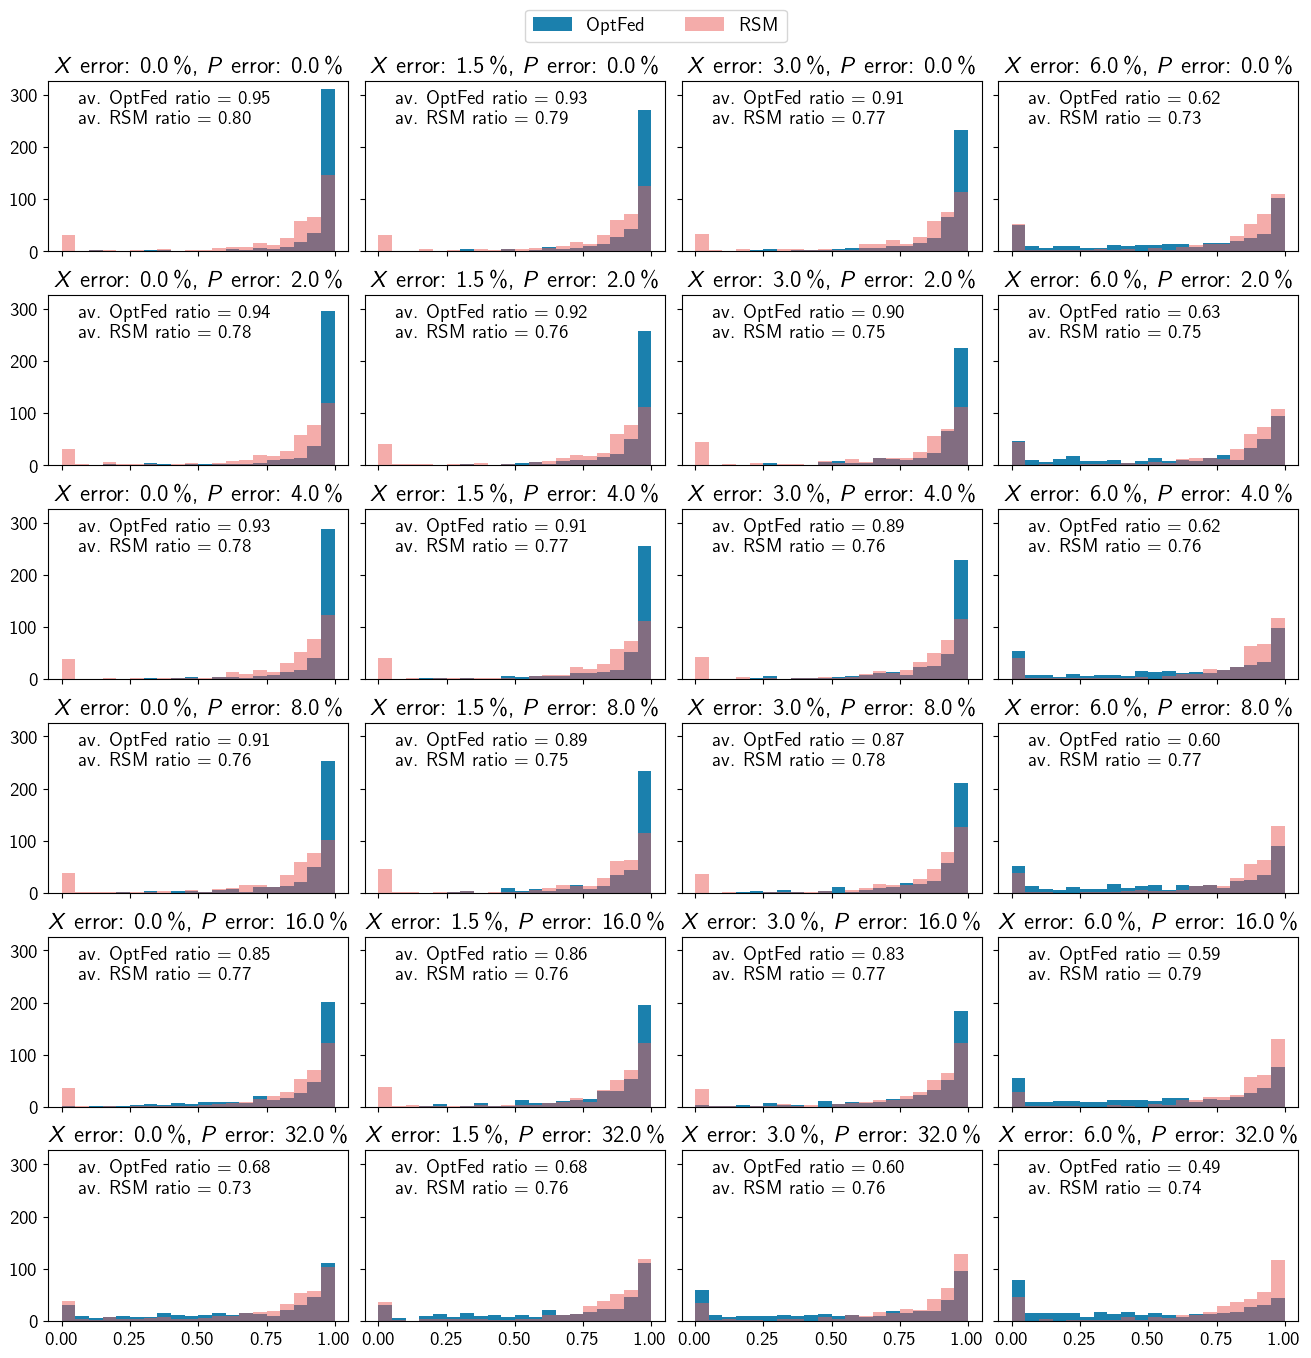

In [5]:
# show how accurately the models predict the optimum for different error levels

errors = df_optima_comparission.error.unique()
errors = [e for e in errors if e[0] <=0.06]

df = df_optima_comparission.copy()
df["est_ratio"] = np.fmin(1, df.est_opt / df.real_opt)
df["rsm_ratio"] = np.fmin(1, df.rsm_opt / df.real_opt)
# values above 1 are set to one as they are numerical errors

fig, axs = plt.subplots(
    6, 4, figsize=(13, 13), layout="constrained", sharex=True, sharey=True
)

for i, (error, ax) in enumerate(
    zip(errors, [axs[i, j] for j in range(axs.shape[1]) for i in range(axs.shape[0])])
):
    df_i = df[df.error == error]
    # df = df[df.no_variables<=10]
    if i == 0:
        label_model = r"\ourmodel"
        label_rsm = "RSM"
    else:
        label_model = None
        label_rsm = None

    ax.hist(
        df_i.est_ratio,
        range=[0, 1],
        bins=20,
        label=label_model,
        color=color_scheme.general[0],
    )
    ax.hist(
        df_i.rsm_ratio,
        range=[0, 1],
        bins=20,
        alpha=0.5,
        label=label_rsm,
        color=color_scheme.general[1],
    )
    # ax.set_title(f"$X$ error: {error[0]}, $P$ error: {error[1]}")
    title_string = (
        r"$X$ error: \qty{"
        + f"{error[0] * 100}"
        + r"}{\percent}, $P$ error: \qty{"
        + f"{error[1] * 100}"
        + r"}{\percent}"
    )
    ax.set_title(title_string)
    ax.text(
        0.1,
        0.75,
        f"av. \ourmodel ratio = {df_i.est_ratio.mean():.2f}\n"
        + f"av. RSM ratio = {df_i.rsm_ratio.mean():.2f}",
        transform=ax.transAxes,
    )
# ax0.set_title(r"no error")
# ax1.set_title(r"simulated error = 1 \% ")
# ax2.set_title(r"simulated error = 2 \% ")
# ax3.set_title(r"simulated error = 5 \% ")
# ax4.set_title(r"simulated error = 10 \% ")

# [ax.set_xlabel("model opt / real opt") for ax in (ax0, ax1, ax2, ax3, ax4)]
# # [ax.set_ylim([0, 500]) for ax in [ax0, ax1]]
# ax0.set_ylabel(f"count (out of {len(df_i.index)})")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2)

plt.savefig(f"{figpath}sim_val_hist.png")

plt.show()

In [6]:
# simplify the plot, just showing mean opt ratios

error_ratios = list()
for e in df.error.unique():
    df_i = df[df.error == e]
    X_error = e[0]
    P_error = e[1]
    mean_model_ratio = df_i.est_ratio.mean()
    mean_rsm_ratio = df_i.rsm_ratio.mean()
    median_model_ratio = df_i.est_ratio.median()
    median_rsm_ratio = df_i.rsm_ratio.median()
    error_ratios.append(
        [
            X_error,
            P_error,
            mean_model_ratio,
            mean_rsm_ratio,
            median_model_ratio,
            median_rsm_ratio,
        ]
    )
df_ratios = pd.DataFrame(
    error_ratios,
    columns=[
        "X_error",
        "P_error",
        "model_mean",
        "rsm_mean",
        "model_median",
        "rsm_median",
    ],
)
# df_ratios

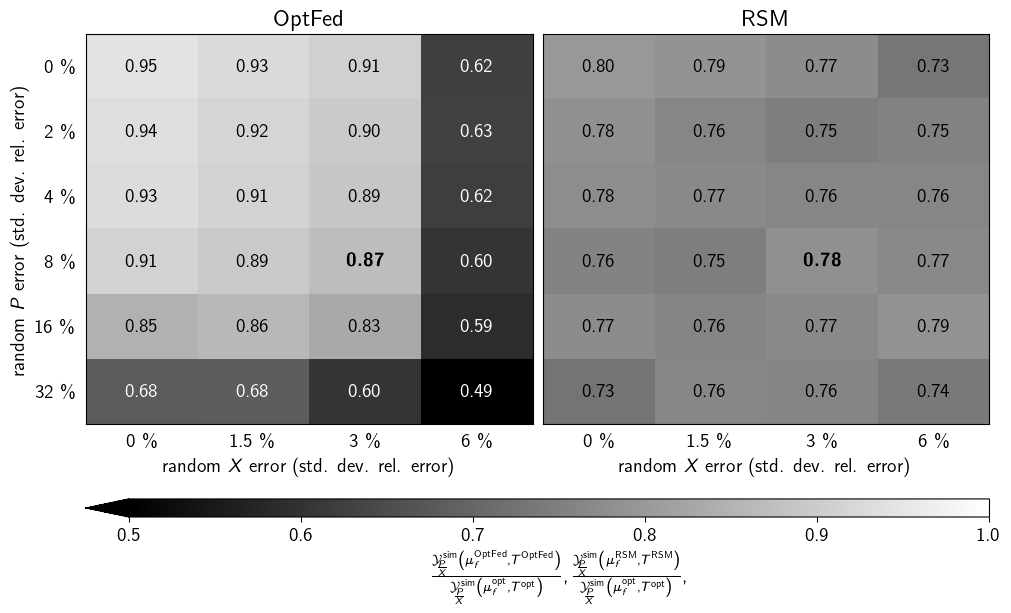

In [7]:
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
#     "", [color_scheme.plus, (1, 1, 1, 1), color_scheme.minus]
# )
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [(0, 0, 0, 1), (1, 1, 1, 1)]
)

df_m = df_ratios.pivot(index="X_error", columns="P_error", values="model_mean").iloc[:-1,:]
df_r = df_ratios.pivot(index="X_error", columns="P_error", values="rsm_mean").iloc[:-1,:]
fig, (ax_m, ax_r) = plt.subplots(
    1, 2, figsize=(10, 6), layout="constrained", sharey=True
)
pm = ax_m.imshow(df_m.T, cmap=cmap, aspect="auto", vmin=0.5, vmax=1)
for (i, j), z in np.ndenumerate(df_m.T):
    if z > 0.7:
        c = "k"
    else:
        c = "w"
    if (i == 3) and (j == 2):
        ax_m.text(j, i, "\\textbf{{{:0.2f}}}".format(z), ha="center", va="center", color=c)
    else:
        ax_m.text(j, i, "{:0.2f}".format(z), ha="center", va="center", color=c),
pr = ax_r.imshow(df_r.T, cmap=cmap, aspect="auto", vmin=0.5, vmax=1)
for (i, j), z in np.ndenumerate(df_r.T):
    if (i == 3) and (j == 2):
        ax_r.text(j, i, "\\textbf{{{:0.2f}}}".format(z), ha="center", va="center")
    else:
        ax_r.text(j, i, "{:0.2f}".format(z), ha="center", va="center")
for ax in ax_m, ax_r:
    ax.set_xticks(
        range(4),
        [f"{i} \%" for i in (0, 1.5, 3, 6)],
    )
    ax.set_yticks(range(6), [f"{i} \%" for i in (0, 2, 4, 8, 16, 32)])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")

    ax.set_xlabel("random $X$ error (std. dev. rel. error)")

ax_m.set_ylabel("random $P$ error (std. dev. rel. error)")
ax_m.set_title("\ourmodel")
ax_r.set_title("RSM")
cbar = fig.colorbar(pm, ax=[ax_m, ax_r], extend="min", location="bottom", aspect=50)
cbar.set_label(
    r"$\frac{\PXend^\text{sim}\left(\mu_f^\text{\ourmodel}, T^\text{\ourmodel}\right)}"
    + r"{\PXend^\text{sim}\left(\mu_f^\text{opt}, T^\text{opt}\right)}, "
    r"\frac{\PXend^\text{sim}\left(\mu_f^\text{RSM}, T^\text{RSM}\right)}"
    + r"{\PXend^\text{sim}\left(\mu_f^\text{opt}, T^\text{opt}\right)}, $"
)

plt.savefig(f"{figpath}sim_val.png", bbox_inches="tight")
plt.show()

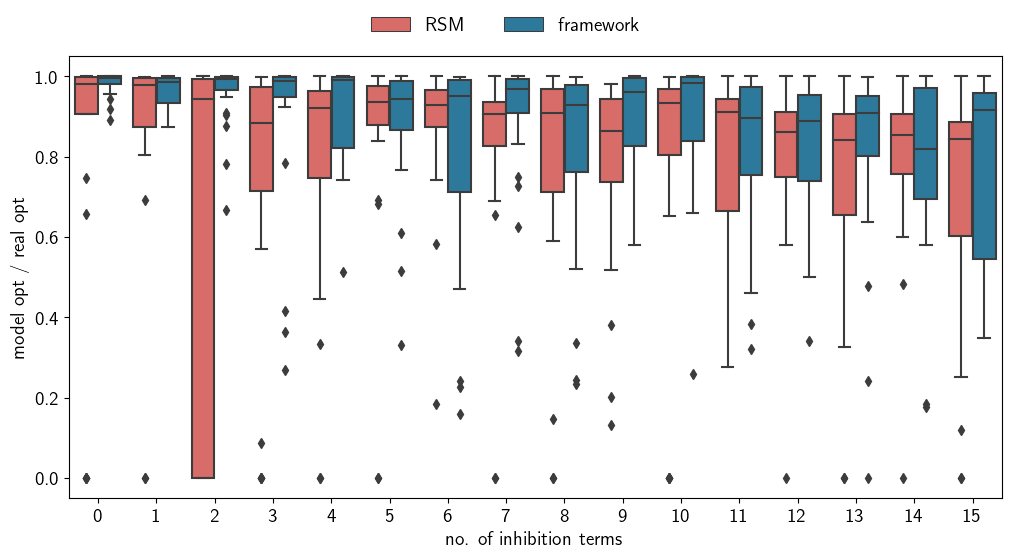

In [8]:
# show the effect of variables of the initial model on performance for experimental error (3% for X, 8% for P)

df = df_optima_comparission.copy()
df1 = df.iloc[:, [0, 1, 3, 5]].copy()
df1["method"] = "RSM"
df1.rename(columns = {"rsm_opt": "est_opt"}, inplace=True)
df2 = df.iloc[:, [0, 1, 3, 4]].copy()
df2["method"] = "framework"
df2.rename(columns = {"est_opt": "est_opt"}, inplace=True)
df = pd.concat([df1, df2], ignore_index=True)
df["error_quotiont"] = np.fmin(1, df.est_opt / df.real_opt)

fig, ax = plt.subplots(
    1, 1, figsize=(10, 5), layout="constrained", sharex=True, sharey=True
)
for i, error in enumerate([(0.03, 0.08, 0, 0, 0, 0)]):
    seaborn.boxplot(
        data=df[df.error == error],
        x="no_variables",
        y="error_quotiont",
        hue="method",
        palette=dict(zip(("framework", "RSM"), color_scheme.general[:2])),
        ax=ax,
        # width=0.8,
    )
    # ax.set_ylim(0, 1.2)
    ax.set_ylabel("model opt / real opt")
    # ax.set_title(f"simulated error = {error * 100} \%")

# [ax.set_xlabel(None) for ax in axs]
ax.set_xlabel("no. of inhibition terms")
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1), frameon=False)
fig.savefig(f"{figpath}sim_validation_box_plots.png", bbox_inches="tight")

plt.show()

In [9]:
df_optima_comparission

,error,no_variables,no,real_opt,est_opt,rsm_opt,real_opt_mu_f,real_opt_T,est_opt_mu_f,est_opt_T,rsm_opt_mu_f,rsm_opt_T
0,"(0.0, 0.0, 0, 0, 0, 0)",0,0,0.068554,0.067696,0.067879,0.140637,304.150000,0.120000,304.150000,0.162265,-5.944689e-20
1,"(0.0, 0.0, 0, 0, 0, 0)",0,1,0.085780,0.085763,0.085375,0.154203,304.150000,0.151365,304.150000,0.168956,3.041500e+02
2,"(0.0, 0.0, 0, 0, 0, 0)",0,2,0.046530,0.049639,0.049612,0.500000,304.150000,0.168305,304.150000,0.176880,3.439809e-19
3,"(0.0, 0.0, 0, 0, 0, 0)",0,3,0.124380,0.124380,0.119665,0.112544,304.150000,0.112560,304.150000,0.150964,-2.951948e-18
4,"(0.0, 0.0, 0, 0, 0, 0)",0,4,0.079273,0.079245,0.079235,0.165067,304.150000,0.157134,304.150000,0.168807,-1.530236e-18
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,"(0.12, 0.32, 0, 0, 0, 0)",15,20,0.098507,0.071289,0.081613,0.093569,302.790478,0.236730,300.000000,0.150387,3.004609e+02
11996,"(0.12, 0.32, 0, 0, 0, 0)",15,21,0.124405,0.110272,0.025295,0.027089,308.394600,0.052074,304.150009,0.288118,2.958241e+02
11997,"(0.12, 0.32, 0, 0, 0, 0)",15,22,0.184727,0.177168,0.104617,0.048514,303.384892,0.047043,304.150000,0.107150,3.002871e+02
11998,"(0.12, 0.32, 0, 0, 0, 0)",15,23,0.164703,0.156267,0.114036,0.039698,303.354634,0.045645,304.148812,0.125850,3.021716e+02


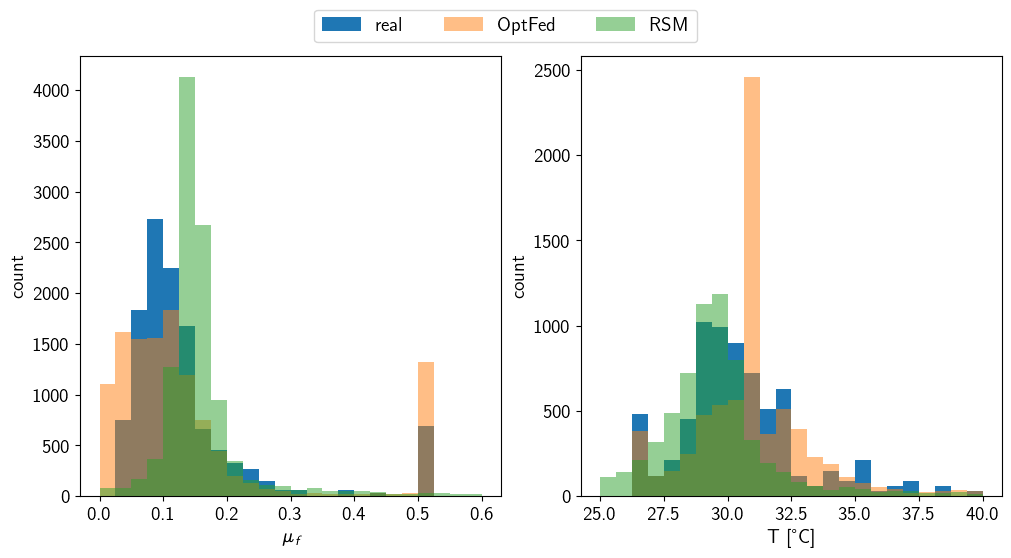

In [10]:
fig, (ax_mu, ax_T) = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
bins_mu = np.linspace(0, 0.6, 25)
ax_mu.hist(df_optima_comparission.real_opt_mu_f, bins=bins_mu, label="real", alpha=1)
ax_mu.hist(df_optima_comparission.est_opt_mu_f, bins=bins_mu, label="\ourmodel", alpha=0.5, zorder=2)
ax_mu.hist(df_optima_comparission.rsm_opt_mu_f, bins=bins_mu, label="RSM", alpha=0.5, zorder=3)
ax_mu.set_xlabel(r"$\mu_f$")

fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=3)

df = df_optima_comparission[(df_optima_comparission.real_opt_T < 304.14) | (df_optima_comparission.real_opt_T > 304.16)]
bins_T = np.linspace(25, 40, 25)
ax_T.hist(df.real_opt_T - 273.15, bins=bins_T, label="real", alpha=1)
ax_T.hist(df.est_opt_T - 273.15, bins=bins_T, label="\ourmodel", alpha=0.5, zorder=2)
ax_T.hist(df.rsm_opt_T - 273.15, bins=bins_T, label="RSM", alpha=0.5, zorder=3)
ax_T.set_xlabel(r"T [\unit{\celsius}]")
ax_mu.set_ylabel("count")
ax_T.set_ylabel("count")

plt.show()

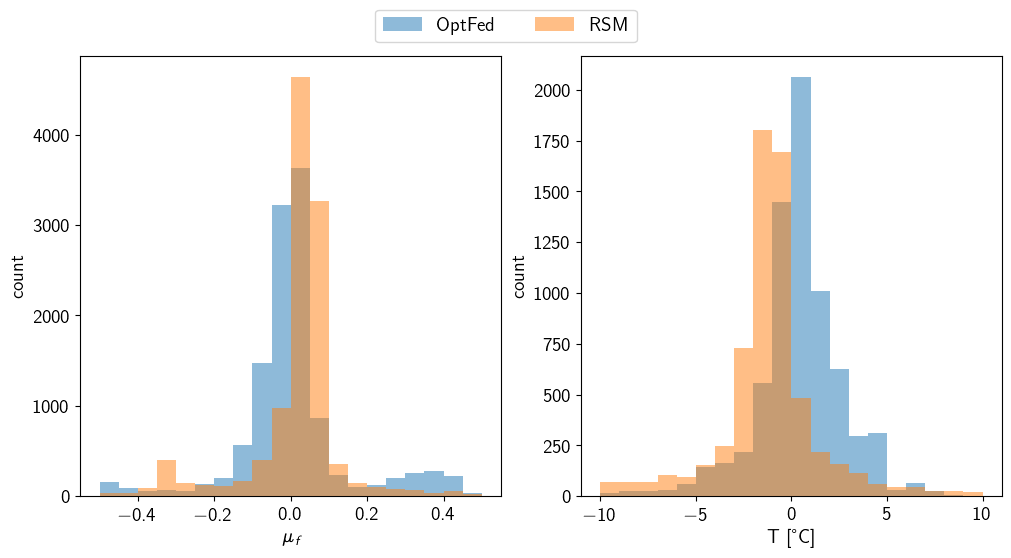

In [11]:
fig, (ax_mu, ax_T) = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
bins_mu = np.linspace(-0.5, 0.5, 21)
ax_mu.hist(df_optima_comparission.est_opt_mu_f - df_optima_comparission.real_opt_mu_f, bins=bins_mu, label="\ourmodel", alpha=0.5, zorder=2)
ax_mu.hist(df_optima_comparission.rsm_opt_mu_f - df_optima_comparission.real_opt_mu_f, bins=bins_mu, label="RSM", alpha=0.5, zorder=3)
ax_mu.set_xlabel(r"$\mu_f$")

fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=3)

df = df_optima_comparission[(df_optima_comparission.real_opt_T < 304.14) | (df_optima_comparission.real_opt_T > 304.16)]
bins_T = np.linspace(-10, 10, 21)
ax_T.hist(df.est_opt_T - df_optima_comparission.real_opt_T, bins=bins_T, label="\ourmodel", alpha=0.5, zorder=2)
ax_T.hist(df.rsm_opt_T - df_optima_comparission.real_opt_T, bins=bins_T, label="RSM", alpha=0.5, zorder=3)
ax_T.set_xlabel(r"T [\unit{\celsius}]")
ax_mu.set_ylabel("count")
ax_T.set_ylabel("count")

plt.show()